# Klasifikasi Sayuran menggunakan SVM dengan Image Preprocessing dan PCA

Model machine learning untuk mengklasifikasikan 15 jenis sayuran menggunakan Support Vector Machine (SVM)

Kelompok 5:
- Muhammad Nur Aziz 2341720237
- Michel Dorani Shiba 2341720113

## 1. Import Library

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
import joblib
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

## 2. Load Dataset

In [2]:
dataset_path = r"d:\kuliah\SMT5\Mlearning\MLearning\dataset"

images = []
labels = []

vegetable_classes = sorted(os.listdir(dataset_path))
print(f"Terdapat {len(vegetable_classes)} kelas sayur:")
print(vegetable_classes)

for class_name in tqdm(vegetable_classes, desc="Load dataset"):
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_path):
        continue
    
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        try:
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                labels.append(class_name)
        except:
            continue

print(f"\nTotal gambar: {len(images)}")
print(f"Label distribution:\n{pd.Series(labels).value_counts()}")

Terdapat 15 kelas sayur:
['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


Load dataset: 100%|██████████| 15/15 [00:30<00:00,  2.00s/it]


Total gambar: 15000
Label distribution:
Bean            1000
Bitter_Gourd    1000
Bottle_Gourd    1000
Brinjal         1000
Broccoli        1000
Cabbage         1000
Capsicum        1000
Carrot          1000
Cauliflower     1000
Cucumber        1000
Papaya          1000
Potato          1000
Pumpkin         1000
Radish          1000
Tomato          1000
Name: count, dtype: int64


## 3. Data Preprocessing - Cropping

Step 1: Crop gambar untuk fokus pada area utama objek sayuran

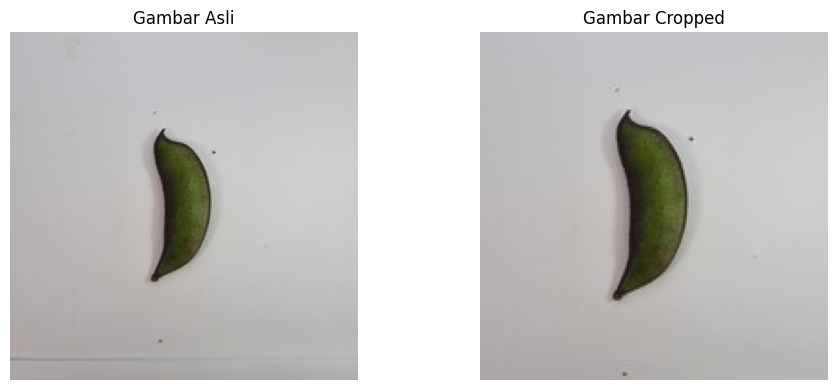

Ukuran Original: (224, 224, 3)
Ukuran Cropped: (180, 180, 3)


In [3]:
def crop_image(image, crop_ratio=0.1):
    h, w = image.shape[:2]
    crop_h = int(h * crop_ratio)
    crop_w = int(w * crop_ratio)
    cropped = image[crop_h:h-crop_h, crop_w:w-crop_w]
    return cropped

img_sample = images[0].copy()
img_cropped_sample = crop_image(img_sample, crop_ratio=0.1)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB))
axes[0].set_title("Gambar Asli")
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(img_cropped_sample, cv2.COLOR_BGR2RGB))
axes[1].set_title("Gambar Cropped")
axes[1].axis('off')
plt.tight_layout()
plt.show()

print(f"Ukuran Original: {img_sample.shape}")
print(f"Ukuran Cropped: {img_cropped_sample.shape}")

In [4]:
images_cropped = []
for img in tqdm(images, desc="Crop semua gambar"):
    cropped_img = crop_image(img, crop_ratio=0.1)
    images_cropped.append(cropped_img)

print(f"Proses cropping selesai: {len(images_cropped)} gambar diproses")

Crop semua gambar: 100%|██████████| 15000/15000 [00:00<00:00, 881563.75it/s]

Proses cropping selesai: 15000 gambar diproses


## 4. Data Preprocessing - Resizing

Step 2: Resize gambar ukuran (128 x 128)

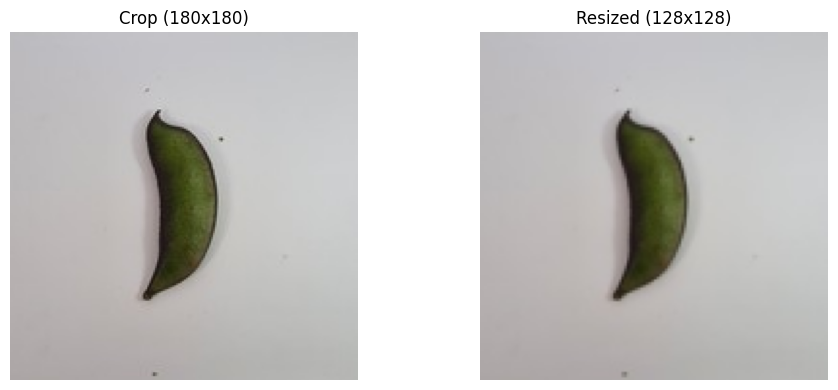

Ukuran Resized: (128, 128, 3)


In [5]:
def resize_image(image, target_size=(128, 128)):
    resized = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
    return resized

img_sample_cropped = images_cropped[0].copy()
img_resized_sample = resize_image(img_sample_cropped)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(cv2.cvtColor(img_sample_cropped, cv2.COLOR_BGR2RGB))
axes[0].set_title(f"Crop ({img_sample_cropped.shape[0]}x{img_sample_cropped.shape[1]})")
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(img_resized_sample, cv2.COLOR_BGR2RGB))
axes[1].set_title(f"Resized ({img_resized_sample.shape[0]}x{img_resized_sample.shape[1]})")
axes[1].axis('off')
plt.tight_layout()
plt.show()

print(f"Ukuran Resized: {img_resized_sample.shape}")

In [6]:
images_resized = []
for img in tqdm(images_cropped, desc="Ubah ukuran semua gambar"):
    resized_img = resize_image(img, target_size=(128, 128))
    images_resized.append(resized_img)

del images_cropped
del images

print(f"Resizing: {len(images_resized)} gambar")

Ubah ukuran semua gambar: 100%|██████████| 15000/15000 [00:03<00:00, 4810.75it/s]



Resizing: 15000 gambar


## 5. Data Preprocessing - Image Enhancement

Step 3: Contrast & Brightness Correction, Noise Removal pakai Gaussian Blur, dan Normalisasi

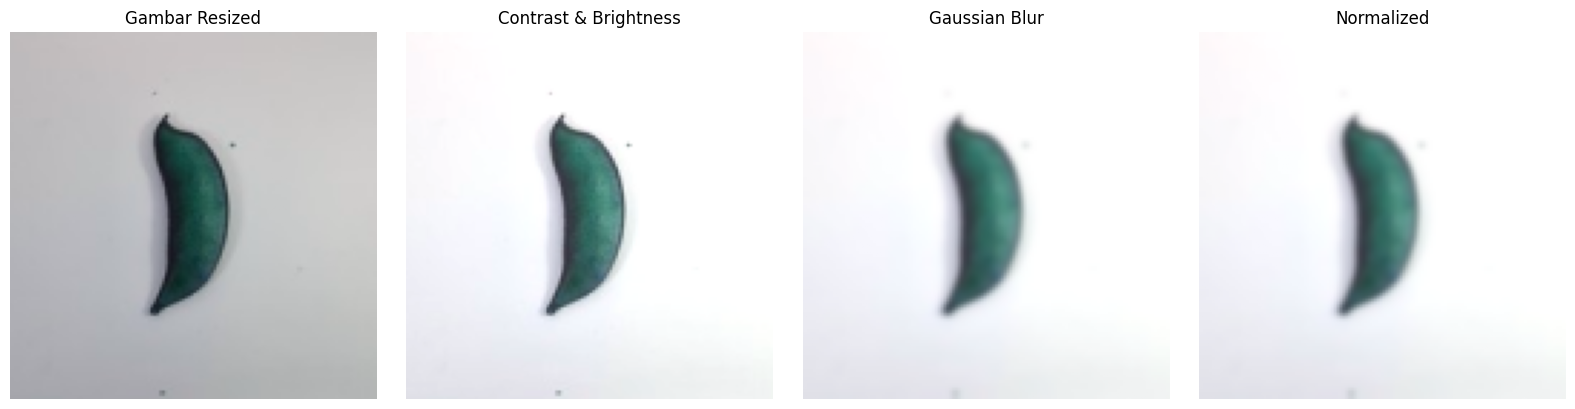

In [7]:
def adjust_contrast_brightness(image, alpha=1.2, beta=0.1):
    adjusted = np.clip(alpha * image + beta, 0, 1)
    return adjusted

def apply_gaussian_blur(image, kernel_size=(5, 5)):
    if image.max() <= 1:
        image = (image * 255).astype(np.uint8)
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return blurred.astype(np.float32) / 255.0

img_sample_resized = images_resized[0].copy().astype(np.float32) / 255.0

img_contrast = adjust_contrast_brightness(img_sample_resized, alpha=1.2, beta=0.1)
img_blurred = apply_gaussian_blur(img_contrast)
img_normalized = np.clip(img_blurred, 0, 1)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(img_sample_resized)
axes[0].set_title("Gambar Resized")
axes[0].axis('off')

axes[1].imshow(img_contrast)
axes[1].set_title("Contrast & Brightness")
axes[1].axis('off')

axes[2].imshow(img_blurred)
axes[2].set_title("Gaussian Blur")
axes[2].axis('off')

axes[3].imshow(img_normalized)
axes[3].set_title("Normalized")
axes[3].axis('off')

plt.tight_layout()
plt.show()

In [8]:
images_enhanced = []
for img in tqdm(images_resized, desc="Terapkan enhancement ke semua gambar"):
    img_float = img.astype(np.float32) / 255.0
    img_contrast = adjust_contrast_brightness(img_float, alpha=1.2, beta=0.1)
    img_blurred = apply_gaussian_blur(img_contrast)
    img_normalized = np.clip(img_blurred, 0, 1)
    images_enhanced.append(img_normalized)

del images_resized

print(f"Enhancement: {len(images_enhanced)} gambar")

Terapkan enhancement ke semua gambar: 100%|██████████| 15000/15000 [00:06<00:00, 2469.92it/s]



Enhancement: 15000 gambar


## 6. Ekstrasi Fitur PCA

PCA untuk reduksi dimensi

Flattening gambar: 100%|██████████| 15/15 [00:02<00:00,  7.37it/s]



Fitur Sebelum PCA: (15000, 49152)
Fitur Sesudah PCA: (15000, 100)
Variasi dijelaskan: 81.29%
Fitur Sesudah PCA: (15000, 100)
Variasi dijelaskan: 81.29%


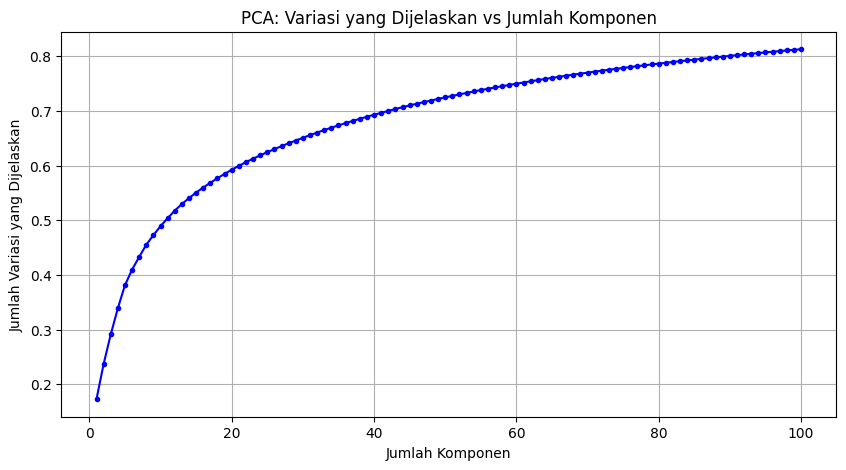

In [9]:
batch_size = 1000
X_batches = []

for i in tqdm(range(0, len(images_enhanced), batch_size), desc="Flattening gambar"):
    batch = [img.flatten() for img in images_enhanced[i:i+batch_size]]
    X_batches.append(np.array(batch))

X = np.vstack(X_batches)
del X_batches
y = np.array(labels)

print(f"Fitur Sebelum PCA: {X.shape}")

n_components = 100
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X)

print(f"Fitur Sesudah PCA: {X_pca.shape}")
print(f"Variasi dijelaskan: {pca.explained_variance_ratio_.sum():.2%}")

del X

explained_var = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_var) + 1), explained_var, 'b-', marker='o', markersize=3)
plt.xlabel('Jumlah Komponen')
plt.ylabel('Jumlah Variasi yang Dijelaskan')
plt.title('PCA: Variasi yang Dijelaskan vs Jumlah Komponen')
plt.grid(True)
plt.show()

## 7. Split Data dan Cross-Validation

Encode labels dan buat train test split dengan 3 proporsi: 
- 70:30
- 80:20
- 90:10
- Cross-validation dengan k=5

In [10]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"Total Classes: {len(le.classes_)}")
print(f"Classes: {le.classes_}")

split_ratios = {
    '90:10': 0.1,
    '80:20': 0.2,
    '70:30': 0.3
}

split_data = {}

for ratio_name, test_size in split_ratios.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca, y_encoded, test_size=test_size, random_state=42, stratify=y_encoded
    )
    
    split_data[ratio_name] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'cv_results': {}
    }
    
    print(f"\n{ratio_name} Split:")
    print(f"  Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
print(f"\nCross-Validation: k=5")

Total Classes: 15
Classes: ['Bean' 'Bitter_Gourd' 'Bottle_Gourd' 'Brinjal' 'Broccoli' 'Cabbage'
 'Capsicum' 'Carrot' 'Cauliflower' 'Cucumber' 'Papaya' 'Potato' 'Pumpkin'
 'Radish' 'Tomato']

90:10 Split:
  Train size: 13500, Test size: 1500

80:20 Split:
  Train size: 12000, Test size: 3000

70:30 Split:
  Train size: 10500, Test size: 4500

Cross-Validation: k=5


In [11]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 0.42],
    'kernel': ['rbf'],
    'gamma': ['scale', 0.1, 0.01, 0.001]
}

best_models = {}
all_cv_fold_results = {ratio: [] for ratio in split_ratios}

for ratio_name, test_size in split_ratios.items():
    print(f"\nProses split {ratio_name}")
    
    X_train = split_data[ratio_name]['X_train']
    X_test = split_data[ratio_name]['X_test']
    y_train = split_data[ratio_name]['y_train']
    y_test = split_data[ratio_name]['y_test']
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    svm = SVC()
    grid_search = GridSearchCV(svm, param_grid, cv=kf, n_jobs=-1, verbose=1)
    
    print("Proses GridSearchCV...")
    grid_search.fit(X_train_scaled, y_train)
    
    best_models[ratio_name] = {
        'model': grid_search.best_estimator_,
        'scaler': scaler,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    y_pred_train = grid_search.best_estimator_.predict(X_train_scaled)
    y_pred_test = grid_search.best_estimator_.predict(X_test_scaled)
    
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    
    print(f"Train accuracy: {train_acc:.4f}")
    print(f"Test accuracy: {test_acc:.4f}")
    
    split_data[ratio_name]['scaler'] = scaler
    split_data[ratio_name]['y_pred_train'] = y_pred_train
    split_data[ratio_name]['y_pred_test'] = y_pred_test


Proses split 90:10
Proses GridSearchCV...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters: {'C': 0.42, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV score: 0.7223

Best parameters: {'C': 0.42, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV score: 0.7223
Train accuracy: 0.8628
Test accuracy: 0.7627

Proses split 80:20
Proses GridSearchCV...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Train accuracy: 0.8628
Test accuracy: 0.7627

Proses split 80:20
Proses GridSearchCV...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters: {'C': 0.42, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV score: 0.7140

Best parameters: {'C': 0.42, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV score: 0.7140
Train accuracy: 0.8573
Test accuracy: 0.7363

Proses split 70:30
Proses GridSearchCV...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Train accuracy: 0.8573
Test accuracy: 0.7363

Proses split 70:30
Proses GridSearchCV...
Fitting 5 fol

## 9. Evaluasi Model dan Perbandingan

Evaluasi performa model menggunakan metriks: Akurasi, Presisi, Recall, F1-Score

In [12]:
evaluation_results = {}

for ratio_name in split_ratios:
    print(f"\n")
    print(f"Evaluasi {ratio_name} split")
    
    y_train = split_data[ratio_name]['y_train']
    y_test = split_data[ratio_name]['y_test']
    y_pred_train = split_data[ratio_name]['y_pred_train']
    y_pred_test = split_data[ratio_name]['y_pred_test']
    
    train_metrics = {
        'accuracy': accuracy_score(y_train, y_pred_train),
        'precision': precision_score(y_train, y_pred_train, average='weighted', zero_division=0),
        'recall': recall_score(y_train, y_pred_train, average='weighted', zero_division=0),
        'f1': f1_score(y_train, y_pred_train, average='weighted', zero_division=0)
    }
    
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_pred_test),
        'precision': precision_score(y_test, y_pred_test, average='weighted', zero_division=0),
        'recall': recall_score(y_test, y_pred_test, average='weighted', zero_division=0),
        'f1': f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
    }
    
    evaluation_results[ratio_name] = {
        'train': train_metrics,
        'test': test_metrics
    }
    
    print(f"\nTraining Set Metrics:")
    for metric, value in train_metrics.items():
        print(f"  {metric.upper()}: {value:.4f}")
    
    print(f"\nTest Set Metrics:")
    for metric, value in test_metrics.items():
        print(f"  {metric.upper()}: {value:.4f}")
    
    print(f"\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred_test, target_names=le.classes_, zero_division=0))



Evaluasi 90:10 split

Training Set Metrics:
  ACCURACY: 0.8628
  PRECISION: 0.8681
  RECALL: 0.8628
  F1: 0.8642

Test Set Metrics:
  ACCURACY: 0.7627
  PRECISION: 0.7732
  RECALL: 0.7627
  F1: 0.7648

Classification Report (Test Set):
              precision    recall  f1-score   support

        Bean       0.56      0.59      0.58       100
Bitter_Gourd       0.78      0.71      0.74       100
Bottle_Gourd       0.92      0.87      0.89       100
     Brinjal       0.55      0.76      0.64       100
    Broccoli       0.70      0.82      0.76       100
     Cabbage       0.77      0.72      0.75       100
    Capsicum       0.88      0.88      0.88       100
      Carrot       0.92      0.85      0.89       100
 Cauliflower       0.69      0.69      0.69       100
    Cucumber       0.90      0.69      0.78       100
      Papaya       0.83      0.88      0.85       100
      Potato       0.80      0.74      0.77       100
     Pumpkin       0.85      0.76      0.80       100
     

## 10. Visualisasi 

Grafik perbandingan performa dari ketiga split (90:10, 80:20, 70:30)

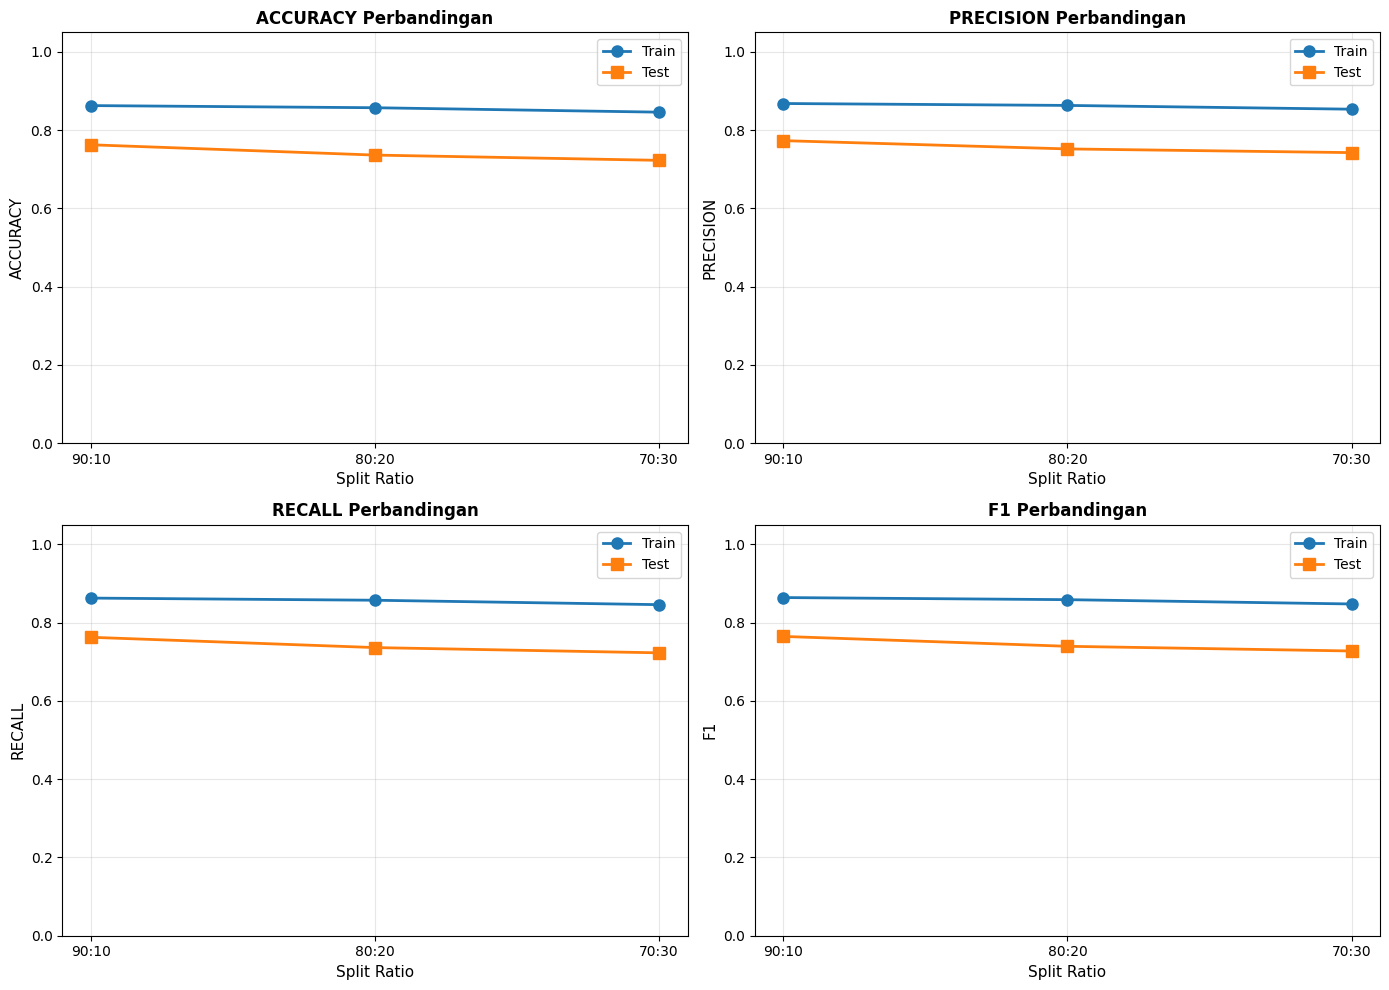

In [13]:
metrics = ['accuracy', 'precision', 'recall', 'f1']
ratio_names = list(split_ratios.keys())

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    train_values = [evaluation_results[ratio]['train'][metric] for ratio in ratio_names]
    test_values = [evaluation_results[ratio]['test'][metric] for ratio in ratio_names]
    
    x = np.arange(len(ratio_names))
    width = 0.35
    
    axes[idx].plot(x, train_values, 'o-', label='Train', linewidth=2, markersize=8)
    axes[idx].plot(x, test_values, 's-', label='Test', linewidth=2, markersize=8)
    
    axes[idx].set_xlabel('Split Ratio', fontsize=11)
    axes[idx].set_ylabel(metric.upper(), fontsize=11)
    axes[idx].set_title(f'{metric.upper()} Perbandingan', fontsize=12, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(ratio_names)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

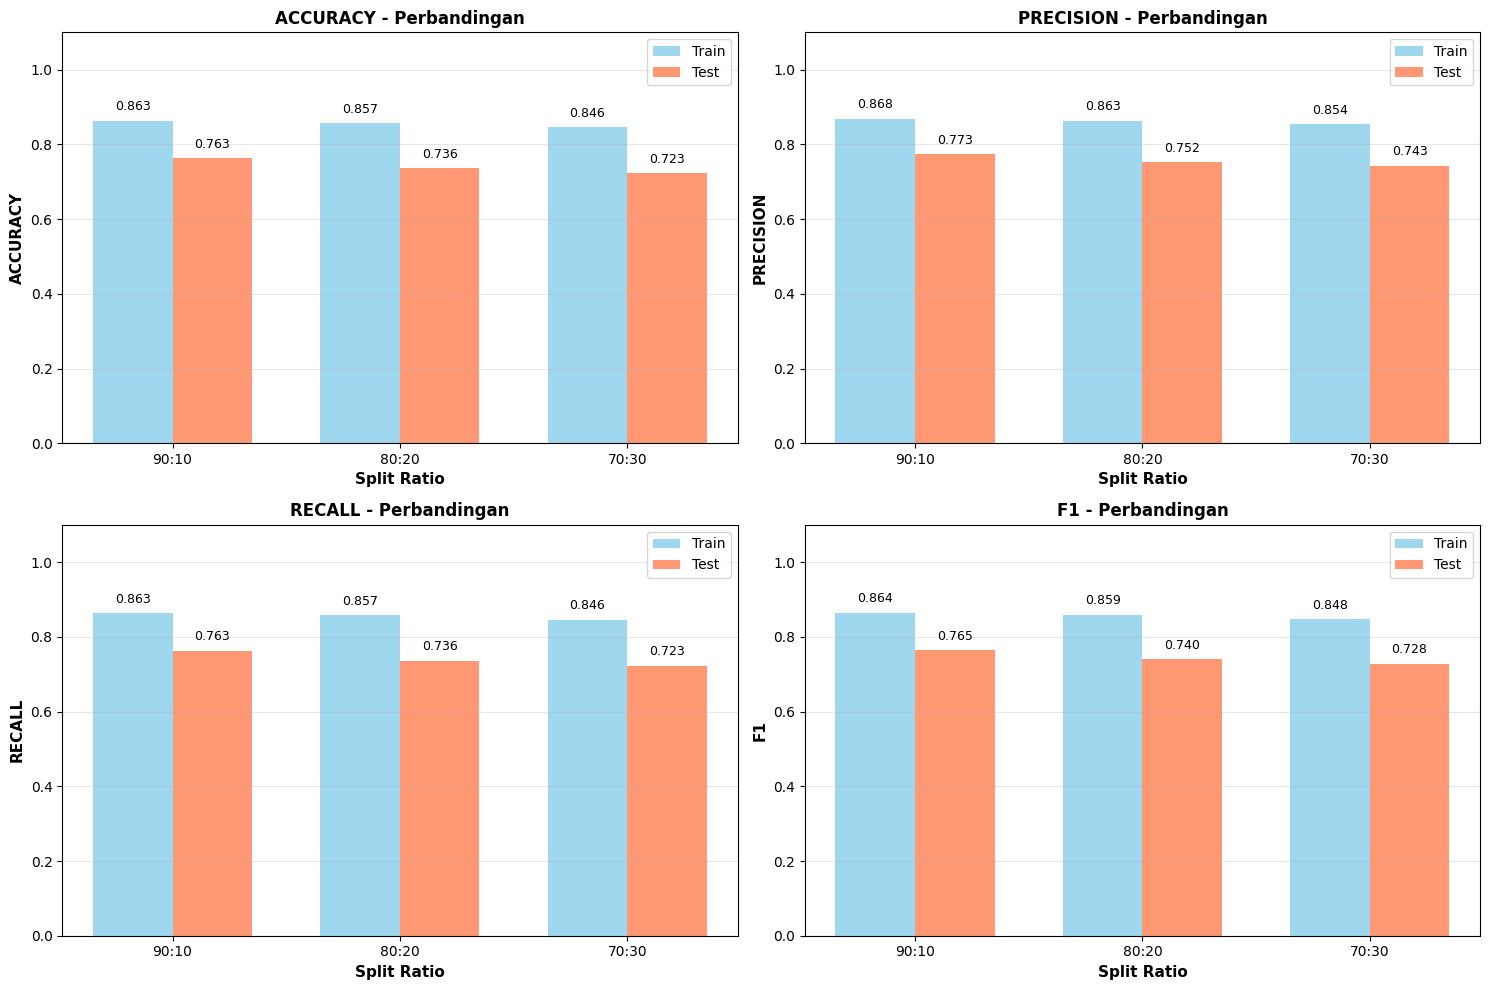

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

metrics = ['accuracy', 'precision', 'recall', 'f1']
ratio_names = list(split_ratios.keys())
x = np.arange(len(ratio_names))
width = 0.35

for idx, metric in enumerate(metrics):
    train_values = [evaluation_results[ratio]['train'][metric] for ratio in ratio_names]
    test_values = [evaluation_results[ratio]['test'][metric] for ratio in ratio_names]
    
    axes[idx].bar(x - width/2, train_values, width, label='Train', alpha=0.8, color='skyblue')
    axes[idx].bar(x + width/2, test_values, width, label='Test', alpha=0.8, color='coral')
    
    axes[idx].set_xlabel('Split Ratio', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel(metric.upper(), fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{metric.upper()} - Perbandingan', fontsize=12, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(ratio_names)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3, axis='y')
    axes[idx].set_ylim([0, 1.1])
    
    for i, (train_val, test_val) in enumerate(zip(train_values, test_values)):
        axes[idx].text(i - width/2, train_val + 0.02, f'{train_val:.3f}', ha='center', va='bottom', fontsize=9)
        axes[idx].text(i + width/2, test_val + 0.02, f'{test_val:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 11. Save Model Terbaik

Simpan model terbaik ke file (.pkl)

In [15]:
best_ratio = max(split_ratios.keys(), 
                  key=lambda x: evaluation_results[x]['test']['accuracy'])

best_model_data = best_models[best_ratio]

model_package = {
    'model': best_model_data['model'],
    'scaler': best_model_data['scaler'],
    'pca': pca,
    'label_encoder': le,
    'best_params': best_model_data['best_params'],
    'split_ratio': best_ratio,
    'performance': evaluation_results[best_ratio]
}

model_path = r"d:\kuliah\SMT5\Mlearning\MLearning\model_sayuran.pkl"
joblib.dump(model_package, model_path)

print(f"Model Terbaik Disimpan di: {model_path}")
print(f"Split Terbaik: {best_ratio}")
print(f"Model Test Akurasi Terbaik: {evaluation_results[best_ratio]['test']['accuracy']:.4f}")

model_loaded = joblib.load(model_path)
print(f"\nModel berhasil diload untuk verifikasi")
print(f"Model parameters: {model_loaded['best_params']}")

Model Terbaik Disimpan di: d:\kuliah\SMT5\Mlearning\MLearning\model_sayuran.pkl
Split Terbaik: 90:10
Model Test Akurasi Terbaik: 0.7627

Model berhasil diload untuk verifikasi
Model parameters: {'C': 0.42, 'gamma': 'scale', 'kernel': 'rbf'}
